In [1]:
from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_pth = Path('../../data/')

In [3]:
time_intervals = pl.read_csv(data_pth/ 'grade_timesteps.csv')

In [4]:
# time_intervals = pl.read_csv(data_pth/ 'time_intervals.csv')

In [5]:
time_intervals_final = time_intervals.group_by('id').agg(pl.col('dt').diff().mean())


In [6]:
df = pl.read_csv(data_pth/'graded_data.csv')
area_delta = df[['id','area']].group_by('id').agg(pl.col('area').max()-pl.col('area').min())

large_blasto_mask = area_delta['area']>8000

selected_ids = area_delta.filter(large_blasto_mask.to_list())['id']

final_df = df.filter(df["id"].is_in(selected_ids))
    

In [7]:
time_intervals.group_by('id').agg(pl.col('dt').diff().mean()).max()['dt']

dt
f64
0.011043


In [8]:
time_intervals.group_by('id').agg(pl.col('dt').diff().mean())

id,dt
str,f64
"""D2019.04.22_S01986_I0149_D_3""",0.010428
"""D2016.02.16_S1229_I149_3""",0.006989
"""D2016.12.16_S1455_I149_2""",0.010442
"""D2018.03.16_S01744_I0149_D_5""",0.010581
"""D2018.07.21_S01854_I0149_D_6""",0.010481
…,…
"""D2018.06.11_S01825_I0149_D_6""",0.010439
"""D2017.11.20_S01664_I0149_D_3""",0.010526
"""D2016.01.30_S1211_I149_5""",0.007025


In [9]:
from scipy.signal import find_peaks
def get_inflection_points(area):
    
    x = np.arange(len(area.to_numpy()))
    y = area  # Your data here


    # Compute the first and second derivatives
    dy = np.gradient(y)
    d2y = np.gradient(dy)

    # Set a threshold for the second derivative
    threshold = np.max(d2y) * 0.3

    sharp_points, _ = find_peaks(d2y, height=threshold)
    
    return sharp_points

In [10]:
4*24

96

In [11]:
import polars as pl
from multiprocessing import Pool, cpu_count

# Example function
# def get_inflection_points(area_series):
#     # Perform computations here
#     return some_result

# Parallel processing wrapper
def process_group(group):
    group_id, group_data, embryo_dt = group
    
    if embryo_dt.is_empty():
        return group_id, 0

    if "dt" not in embryo_dt.columns:
        raise ValueError(f"Column 'dt' not found in time_intervals_final for id {group_id[0]}")

    # Compute peaks
    peaks = get_inflection_points(group_data["area"])

    # Ensure dt_in_hours is a scalar or iterable
    dt_in_hours = embryo_dt["dt"].item()*1440/60  # Convert to list

    # if len(dt_in_hours) != 1:
    #     raise ValueError(f"Expected one dt value per group but found {len(dt_in_hours)} for id {group_id[0]}")

    # Extract the scalar value for dt
    dt_in_hours_scalar = dt_in_hours

    # Filter peaks
    ok_peaks = [peak for peak in peaks if peak * dt_in_hours > 96]

    # Return the minimum valid peak
    return group_id, min(ok_peaks, default=None)

# Extract groups, process in parallel, and reconstruct
def parallel_map_groups(df, group_column, time_intervals_final):
    grouped = df.group_by(group_column, maintain_order=True)
    groups = [
        (group_id, group_data, time_intervals_final.filter(pl.col("id") == group_id[0]))
        for group_id, group_data in grouped
    ]
    
    # Set process count based on available cores
    num_processes = min(len(groups), cpu_count())

    with Pool(processes=num_processes) as pool:
        results = pool.map(process_group, groups)
    
    # Filter out groups with no valid peaks
    results = [(group_id, corr) for group_id, corr in results if corr is not None]
    
    # Rebuild the dataframe
    return pl.DataFrame({"id": [result[0][0] for result in results], "peak": [result[1] for result in results]})

# Apply to your data
peaks_area = parallel_map_groups(final_df, "id", time_intervals_final)



In [64]:
final_df['id'].unique()

id
str
"""D2017.05.18_S1555_I149_3"""
"""D2018.05.05_S01789_I0149_D_11"""
"""D2018.03.20_S01749_I0149_D_5"""
"""D2019.02.15_S01951_I0149_D_7"""
"""D2016.03.13_S1258_I149_11"""
…
"""D2016.10.15_S1415_I149_8"""
"""D2018.04.21_S01773_I0149_D_4"""
"""D2016.05.03_S1296_I149_5"""


In [72]:
final_df.filter(pl.col('id')=='D2016.03.13_S1258_I149_11')['area'].shape

(698,)

In [73]:
peaks_area.write_csv(data_pth/'area_peaks.csv')

In [86]:
area = final_df.filter(pl.col('id')=='D2016.03.13_S1258_I149_11')['area'].to_numpy()

In [87]:
dy = np.gradient(area)

In [88]:
d2y = np.gradient(dy)

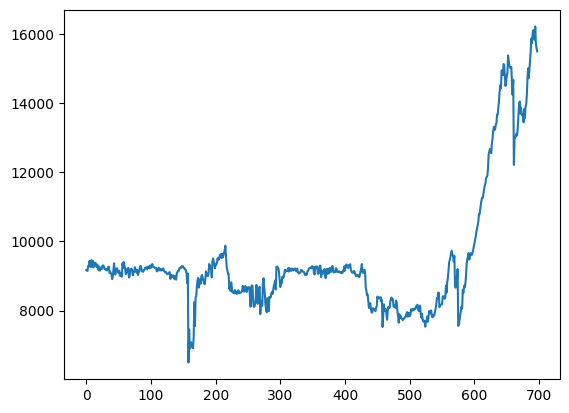

In [91]:
plt.plot(area)

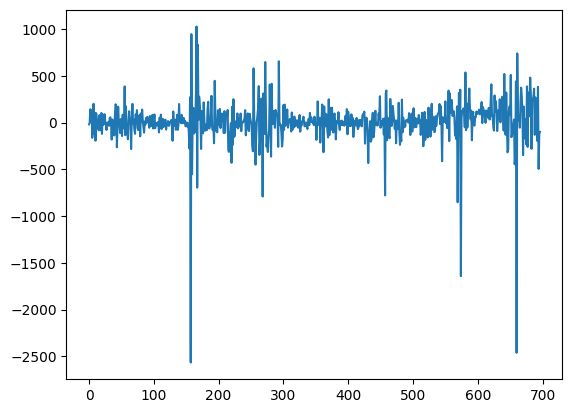

In [90]:
plt.plot(np.diff(area))

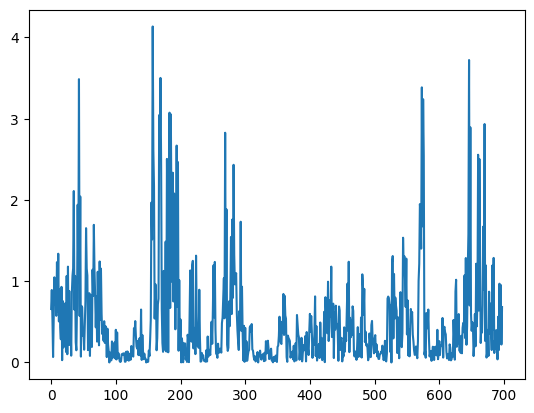

In [85]:
plt.plot(np.abs(d2y))

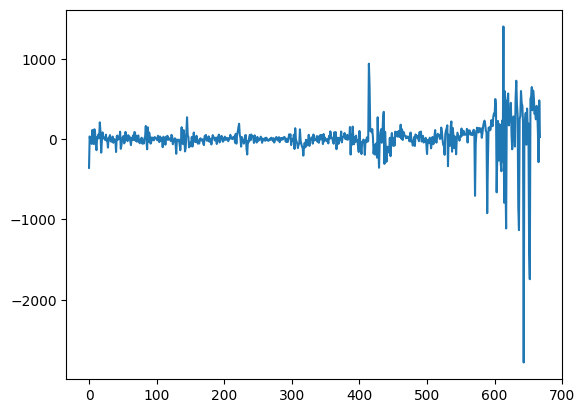

In [35]:
plt.plot(np.diff(final_df.filter(pl.col('id')=='D2016.01.05_S1181_I149_6')['area'].to_numpy()))